# 023. mnist dataset 손글씨 인식 - LeNet

- CNN 을 이용한 mnist dataset 손글씨 인식  
- Yan LeCunn 이 1998 년 발표한 LeNet-5 을 Pytorch 로 customize 하여 재현

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
# CUDA for PyTorch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
composed = transforms.Compose([
                    transforms.Resize((28, 28)), 
                    transforms.ToTensor(),
                    transforms.Normalize((0.1,), (0.3,))])

In [4]:
# load mnist data
train_data = dsets.MNIST(root='./data', train=True, download=True, transform=composed)

test_data = dsets.MNIST(root='./data', train=False, download=True, transform=composed)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
print(train_data)
print()
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.1,), std=(0.3,))
           )

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.1,), std=(0.3,))
           )


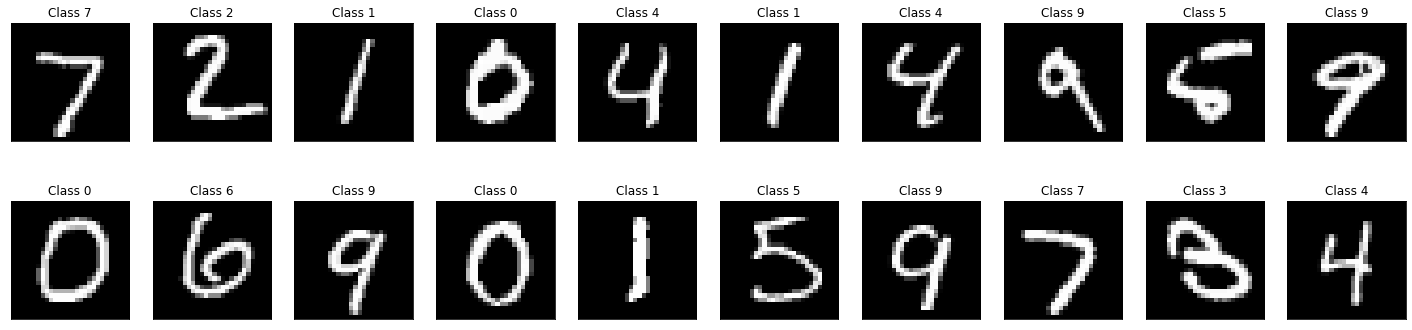

In [6]:
plt.figure(figsize=(25, 6))
for i, (x, y) in enumerate(test_data):
    if i > 19:
        break
    plt.subplot(2, 10, i+1)
    plt.imshow(x.numpy().reshape(28, 28), cmap='gray')  
    plt.title("Class {}".format(y))
    plt.xticks([])
    plt.yticks([])

plt.show()

### Dataset Loader

In [7]:
len(train_data)

60000

In [8]:
train_idx = range(len(train_data))
test_idx  = range(len(test_data))

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

In [9]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, sampler=train_sampler)
test_loader  = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, sampler=test_sampler)

## Model build

In [71]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.maxpool = nn.MaxPool2d(2)  #pool size = 2
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x) 
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)    
        return x

In [72]:
model = LeNet()
model = model.to(device)

In [73]:
[(k, v.numel()) for k, v in model.state_dict().items()]

[('conv1.weight', 150),
 ('conv1.bias', 6),
 ('conv2.weight', 2400),
 ('conv2.bias', 16),
 ('fc1.weight', 48000),
 ('fc1.bias', 120),
 ('fc2.weight', 10080),
 ('fc2.bias', 84),
 ('fc3.weight', 840),
 ('fc3.bias', 10)]

In [74]:
"total parameters {}".format(sum(p.numel() for p in model.parameters()))

'total parameters 61706'

### Model Summary

In [75]:
model

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)

### Loss Function

In [76]:
criterion = nn.CrossEntropyLoss()
# loss 를 gpu 로 transfer
criterion = criterion.to(device)

In [77]:
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [78]:
LOSS = {'train_loss': [], 'test_loss': []}
EPOCHS = 5

for epoch in range(EPOCHS):
    
    model.train()  # train mode
    
    train_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
    
        z = model(x)
        loss = criterion(z, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_loss = train_loss/len(train_loader)
    LOSS['train_loss'].append(train_loss)
    
    model.eval()   # evaluation mode
        
    test_loss = 0
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        
        z = model(x)
        loss = criterion(z, y)
        test_loss += loss.item()
        
    test_loss = test_loss / len(test_loader)
    LOSS['test_loss'].append(test_loss)
    
    print(f'epoch {epoch} ==> train loss: {train_loss}, \
          test loss: {test_loss}')

epoch 0 ==> train loss: 1.9280134706354852,           test loss: 0.7337045284766185
epoch 1 ==> train loss: 0.4291077887198564,           test loss: 0.2807100336008434
epoch 2 ==> train loss: 0.23261904090579386,           test loss: 0.16809434693636774
epoch 3 ==> train loss: 0.16465105558795207,           test loss: 0.11922560608651064
epoch 4 ==> train loss: 0.12885237005410163,           test loss: 0.11140215415743333


Text(0, 0.5, 'total loss')

<Figure size 576x288 with 0 Axes>

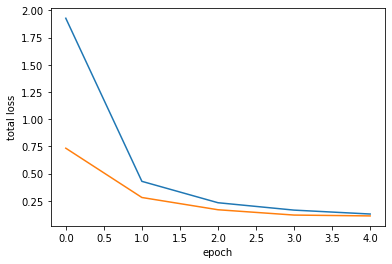

In [79]:
plt.figure(figsize=(8, 4))

fig, ax = plt.subplots()
ax.plot(LOSS['train_loss'], label='train loss')
ax.plot(LOSS['test_loss'], label='test loss')
ax.set_xlabel('epoch')
ax.set_ylabel('total loss')

### Model 평가

In [80]:
predictions = []
labels = []

model.eval()

for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    z = model(x)
    _, y_pred = torch.max(z, 1)
    predictions.extend(y_pred.cpu().numpy())
    labels.extend(y.cpu().numpy())
    
correct_indices = np.nonzero(np.array(predictions) == np.array(labels))[0]
incorrect_indices = np.nonzero(np.array(predictions) != np.array(labels))[0]
    
print("accuracy = {:.2f}%".format(len(correct_indices) / len(predictions) * 100))

accuracy = 96.52%


Text(51.0, 0.5, 'Predicted Value')

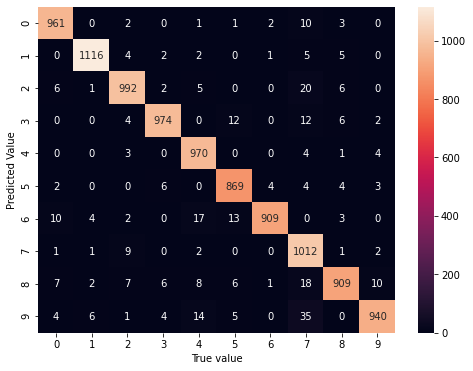

In [81]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt='d')
ax.set_xlabel('True value')
ax.set_ylabel('Predicted Value')

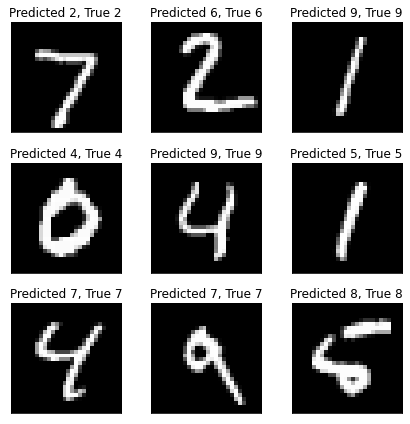

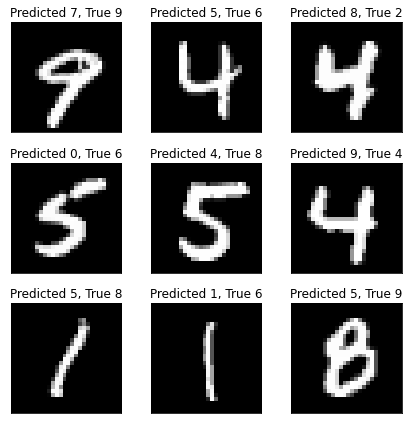

In [82]:
plt.figure(figsize=(6, 6))
for i, idx in enumerate(correct_indices[:9]):
    plt.subplot(3, 3, i+1)
    plt.imshow(test_data[idx][0].view(28, 28), cmap='gray')
    plt.title("Predicted {}, True {}".format(predictions[idx], labels[idx]))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

plt.figure(figsize=(6, 6))
for i, idx in enumerate(incorrect_indices[:9]):
    plt.subplot(3, 3, i+1)
    plt.imshow(test_data[idx][0].view(28, 28), cmap='gray')
    plt.title("Predicted {}, True {}".format(predictions[idx], labels[idx]))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()